In [424]:
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import torch
from gpzoo.utilities import train, deviancePoisson, rescale_spatial_coords, anndata_to_train_val, regularized_nmf
import gpzoo.pri_experiment_utilities as putil
from gpzoo.gp import SVGP, VNNGP, GaussianPrior
from gpzoo.likelihoods import PNMF
import scanpy as sc
from os import path
import random
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
from torch import optim, distributions, nn
from sklearn.metrics import root_mean_squared_error, mean_poisson_deviance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import ast

import gseapy as gps
from gseapy.plot import barplot, dotplot

import warnings
warnings.filterwarnings("ignore") 

In [2]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")
y_train = Dtr['Y'].T
y_train = y_train[~adata.var.MT]
X_train = Dtr['X']*50

V_train = Dtr['sz']

In [3]:
X_train.shape

(39694, 2)

In [4]:
y_train.shape

(17702, 39694)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(256)
random_seed = 256

cuda:0


In [6]:
ROOT_PATH = '/engelhardt/home/pshrestha/vnngp/'
RPATH = path.join(ROOT_PATH, "results/")
SPATH = path.join(RPATH, "slideseq/")
FPATH = path.join(SPATH, "plots/")
nnnsf_path = path.join(SPATH, "nnnsf/")
nsf_path = path.join(SPATH, "nsf/")
nmf_path = path.join(SPATH, "nmf/")

In [7]:
nums = [int(i+1) for i in range(15)]
print(nums)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [8]:
inducing_points = [50, 1000, 2000, 3000, 4000, 5000]
K = [2, 4, 8]

In [9]:
def plot_top_genes(factors, loadings, X, y, num_genes= 5, size=2, alpha=0.8, s=0.1, names=None):

    max_val_factors = np.percentile(factors, 99)
    min_val_factors = np.percentile(factors, 1)

    L = len(factors)//2


    loadings_softmax = torch.nn.functional.softmax(loadings, dim=1)

    order = torch.argsort(loadings_softmax, dim=0, descending=True)

    y_top = y[order[:num_genes]]
    fig, ax = plt.subplots(L, num_genes+1, figsize=(size*(num_genes+1), size*L), tight_layout=True)

    for i in range(L):
        

        curr_ax = ax[i, 0]
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val_factors, vmax=max_val_factors, alpha=alpha, cmap='turbo', s=s)
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

        names = adata.var.index[order[:num_genes, i]]


        for j in range(num_genes):
            
            curr_ax = ax[i, j+1]
            curr_ax.scatter(X[:, 0], X[:,1], c=y_top[j, i], alpha=alpha, cmap='turbo', s=s)
            curr_ax.invert_yaxis()
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])
            curr_ax.set_facecolor('xkcd:gray')

            curr_ax.set_title(names[j], x=0.03, y=.88, fontsize="small", c="white",
                         ha="left", va="top", fontweight="bold")
    return fig

### Calculate Metrics

In [8]:
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L=10.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L=10.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

In [11]:
params = {
        'L': [10], 
        'K': [2],
        'M': inducing_points, 
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 64,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}
eval_function = mean_poisson_deviance
torch.cuda.empty_cache()
X = torch.tensor(X_train)
Y = np.array(y_train)
nnnsf_k_experiments_rmse = putil.calculate_eval_metric(X, Y, params, SPATH, eval_function=eval_function, train=False, hybrid=False, model_type='VNNGP')

/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=50_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 50 neighbors/IPs:  0.0764026
/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=1000_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 1000 neighbors/IPs:  0.07248957
/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=2000_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 2000 neighbors/IPs:  0.07335494
/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=3000_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 3000 neighbors/IPs:  0.07270977
/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=4000_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 4000 neighbors/IPs:  0.0725

In [10]:
params = {
        'L': [10], 
        'K': [2],
        'M': inducing_points, 
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 64,
        'lr': 1e-3,
        'rs': 1,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}
eval_function = mean_poisson_deviance
torch.cuda.empty_cache()
X = torch.tensor(X_train)
Y = np.array(y_train)
nnnsf_k_experiments_rmse = putil.calculate_eval_metric(X, Y, params, SPATH, eval_function=eval_function, train=False, hybrid=False, model_type='VNNGP')

/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=50_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 50 neighbors/IPs:  0.0764026
/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=1000_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 1000 neighbors/IPs:  0.07248957
/engelhardt/home/pshrestha/vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=2000_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 10 factors and 2000 neighbors/IPs:  0.07335494


KeyboardInterrupt: 

In [ ]:
nnnsf_k_experiments_rmse_df = pd.DataFrame(nnnsf_k_experiments_rmse['5'], index=inducing_points, columns=[2, 4, 8])
nnnsf_k_experiments_rmse_df.to_csv(path.join(SPATH, 'slideseq_rmse_nnnsf_factor5.csv'))

In [17]:
params = {
        'L': [15], 
        'K': [2, 4, 8],
        'M': inducing_points, 
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'SVGP',
        'L1_jitter': 1e-1}
eval_function = mean_poisson_deviance
torch.cuda.empty_cache()
X = torch.tensor(X_train)
Y = np.array(y_train)
nsf_k_experiments_rmse = putil.calculate_eval_metric(X, Y, params, SPATH, eval_function=eval_function, train=False, hybrid=False, model_type='SVGP')

/engelhardt/home/pshrestha/vnngp/results/slideseq/nsf/SVGP_M=50_L=15_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 15 factors and 50 neighbors/IPs:  0.076808855
/engelhardt/home/pshrestha/vnngp/results/slideseq/nsf/SVGP_M=1000_L=15_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 15 factors and 1000 neighbors/IPs:  0.07435024
/engelhardt/home/pshrestha/vnngp/results/slideseq/nsf/SVGP_M=2000_L=15_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 15 factors and 2000 neighbors/IPs:  0.073376134
/engelhardt/home/pshrestha/vnngp/results/slideseq/nsf/SVGP_M=3000_L=15_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 15 factors and 3000 neighbors/IPs:  0.07278444
/engelhardt/home/pshrestha/vnngp/results/slideseq/nsf/SVGP_M=4000_L=15_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 15 factors and 4000 neighbors/IPs:  0.072507955
/engelhardt/home/pshrestha/vnngp/results/slideseq/nsf/SVGP_M=

In [18]:
nsf_k_experiments_rmse_df = pd.DataFrame(nsf_k_experiments_rmse['15'], index=inducing_points, columns=['15'])
nsf_k_experiments_rmse_df.to_csv(path.join(SPATH, 'slideseq_poi_nsf_factor15.csv'))

In [38]:
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L=15.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L=15.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

In [39]:
nnnsf_runtimes = {50: [], 1000: [], 2000: [], 3000: [], 4000: [], 5000: []}
nnnsf_pois = {50: [], 1000: [], 2000: [], 3000: [], 4000: [], 5000: []}
for k in K:
    for M in inducing_points:
        dicts = {
        'L': 15, 
        'M': M, 
        'K': k,
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}
        print(f"---------*********  K={dicts['K']}, M={dicts['M']}  *********---------")
        NNNSF = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)

        file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
        modelname = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
        #nnnsf_path = path.join(nnnsf_path)
        dict_path = path.join(nnnsf_path, file_path)
        model_path = path.join(nnnsf_path, modelname)
        if not path.exists(model_path):
            print(model_path)
            nnnsf_runtimes[M].append(np.nan)
            print(f"No trained model")
            continue
            
        NNNSF.load_state_dict(torch.load(dict_path))
        nnnsf_model_dict = torch.load(model_path)
        print("Runtime: ", (nnnsf_model_dict['time']))
        nnnsf_runtimes[M].append(nnnsf_model_dict['time'])
        #print("RMSE: ", rmse)
        #print("Poisson Deviance: ", poid)

---------*********  K=2, M=50  *********---------
Runtime:  27.99868083000183
---------*********  K=2, M=1000  *********---------
Runtime:  371.2161555290222
---------*********  K=2, M=2000  *********---------
Runtime:  197.95998620986938
---------*********  K=2, M=3000  *********---------
Runtime:  413.56263494491577
---------*********  K=2, M=4000  *********---------
Runtime:  707.6700007915497
---------*********  K=2, M=5000  *********---------
Runtime:  6500.724455356598
---------*********  K=4, M=50  *********---------
Runtime:  27.924702405929565
---------*********  K=4, M=1000  *********---------
Runtime:  70.74967432022095
---------*********  K=4, M=2000  *********---------
Runtime:  201.48440504074097
---------*********  K=4, M=3000  *********---------
Runtime:  416.7100749015808
---------*********  K=4, M=4000  *********---------
Runtime:  714.6289556026459
---------*********  K=4, M=5000  *********---------
Runtime:  1091.1991593837738
---------*********  K=8, M=50  ********

In [40]:
nsf_runtimes = {50: [], 1000: [], 2000: [], 3000: [], 4000: [], 5000: []}
for M in inducing_points:
    dicts = {
        'L': 15, 
        'M': M, 
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 64,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'SVGP',
        'L1_jitter': 1e-1}
    print(f"---------********* M={dicts['M']}  *********---------")
    NSF = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='SVGP', kwargs=dicts)
    file_path = f"SVGP_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
    modelname = f"SVGP_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
    dict_path = path.join(nsf_path, file_path)
    model_path = path.join(nsf_path, modelname)
    if not path.exists(model_path):
        print(model_path)
        nsf_runtimes[M].append(np.nan)
        print(f"No trained model")
        continue
            
    NSF.load_state_dict(torch.load(dict_path))
    nsf_model_dict = torch.load(model_path)
    print("Runtime: ", (nsf_model_dict['time']))
    nsf_runtimes[M].append(nsf_model_dict['time'])
        #print("RMSE: ", rmse)
        #print("Poisson Deviance: ", poid)

---------********* M=50  *********---------
Runtime:  32.16540598869324
---------********* M=1000  *********---------
Runtime:  341.7127299308777
---------********* M=2000  *********---------
Runtime:  1403.9738755226135
---------********* M=3000  *********---------
Runtime:  3937.934617996216
---------********* M=4000  *********---------
Runtime:  8551.665406703949
---------********* M=5000  *********---------
/engelhardt/home/pshrestha/vnngp/results/slideseq/nsf/SVGP_M=5000_L=15_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt
No trained model


In [41]:
nnnsf_runtime_df = pd.DataFrame(nnnsf_runtimes, index=[2, 4, 8])
nnnsf_runtime_df.to_csv(path.join(SPATH, 'slideseq_nnnsf_runntime_factor15.csv'))
nsf_runtime_df = pd.DataFrame(nsf_runtimes)
nsf_runtime_df.to_csv(path.join(SPATH, 'slideseq_nsf_runntime_factor15.csv'))

### Plots

In [121]:
poi = pd.read_csv(path.join(SPATH, 'slideseq_poi_nnnsf_factor10.csv'), index_col=0)
rmse = pd.read_csv(path.join(SPATH, 'slideseq_rmse_nnnsf_factor10.csv'), index_col=0)
poi_nsf = pd.read_csv(path.join(SPATH, 'slideseq_poi_nsf_factor10.csv'), index_col=0)
rmse_nsf = pd.read_csv(path.join(SPATH, 'slideseq_rmse_nsf_factor10.csv'), index_col=0)

In [122]:
#rmse = rmse.drop(50)
#rmse_nsf = rmse_nsf.drop(50)

In [123]:
poi = poi.drop('4', axis=1)
rmse = rmse.drop('4', axis=1)

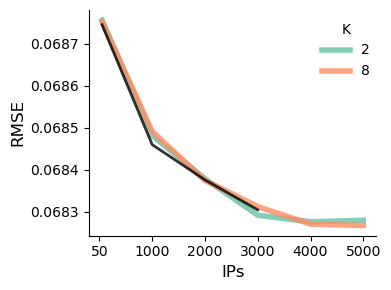

In [333]:
rmse_long = rmse.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='RMSE')
rmse_long['Number of Neighbors'] = rmse_long['Number of Neighbors'].astype(str)
rmse_long_nsf = rmse_nsf.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='RMSE')
rmse_long_nsf['Number of Neighbors'] = rmse_long_nsf['Number of Neighbors'].astype(str)


fig, ax = plt.subplots(figsize=(4, 3))
sns.lineplot(rmse_long, x='index', y='RMSE', hue='Number of Neighbors', ci=None, palette='Set2', legend=True, alpha=0.8, linewidth=4, zorder=0)
sns.lineplot(rmse_long_nsf[:4], x='index', y='RMSE', color='black', ci=None, palette='Set2', legend=True, alpha=0.8, linewidth=2, zorder=1)

ax.legend(loc="upper right", title="K", bbox_to_anchor=(1.02, 1.0), frameon=False, fontsize=10, title_fontsize=10)

ax.set_ylabel("RMSE", size=12)
ax.set_xlabel("IPs", size=12)

# Set custom x-ticks and y-ticks
ax.set_yticklabels([f'{y:.4f}' for y in ax.get_yticks()], fontsize=10)  # Labels for the ticks
ax.set_xticklabels([0, 50, 1000, 2000, 3000, 4000, 5000], fontsize=10)
sns.despine()
plt.tight_layout()
fig.savefig(f"{FPATH}/slideseq_rmse.png")
plt.show()

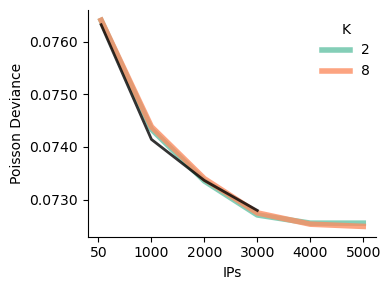

In [332]:
poi_long = poi.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='RMSE')
poi_long['Number of Neighbors'] = poi_long['Number of Neighbors'].astype(str)
#poi_long_nsf = poi_nsf.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='RMSE')
#poi_long_nsf['Number of Neighbors'] = poi_long_nsf['Number of Neighbors'].astype(str)
poi_long_nsf = poi_nsf.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='RMSE')
poi_long_nsf['Number of Neighbors'] = poi_long_nsf['Number of Neighbors'].astype(str)

fig, ax = plt.subplots(figsize=(4, 3))
sns.lineplot(poi_long, x='index', y='RMSE', hue='Number of Neighbors', ci=None, palette='Set2', legend=True, alpha=0.8, linewidth=4, zorder=0)
#sns.lineplot(poi_long_nsf, x='index', y='RMSE', color='black', ci=None, palette='Set2', legend=True, alpha=0.8, linewidth=2, zorder=1)
sns.lineplot(poi_long_nsf[:4], x='index', y='RMSE', color='black', ci=None, palette='Set2', legend=True, alpha=0.8, linewidth=2, zorder=0)

ax.legend(loc="upper right", title="K", bbox_to_anchor=(1.02, 1.0), frameon=False, fontsize=10, title_fontsize=10)

ax.set_ylabel("Poisson Deviance", size=10)
ax.set_xlabel("IPs", size=10)

# Set custom x-ticks and y-ticks
ax.set_yticklabels([f'{y:.4f}' for y in ax.get_yticks()], fontsize=10) 
ax.set_xticklabels([0, 50, 1000, 2000, 3000, 4000, 5000], fontsize=10)# Labels for the ticks
sns.despine()
plt.tight_layout()
fig.savefig(f"{FPATH}/slideseq_poi.png")
plt.show()

In [319]:
nnnsf_runtime_df = pd.read_csv(path.join(SPATH, 'slideseq_nnnsf_runntime_factor10.csv'), index_col=0)
nsf_runtime_df = pd.read_csv(path.join(SPATH, 'slideseq_nsf_runntime_factor10.csv'), index_col=0)

nnnsf_runtime_df5 = pd.read_csv(path.join(SPATH, 'slideseq_nnnsf_runntime_factor5.csv'), index_col=0)
nsf_runtime_df5 = pd.read_csv(path.join(SPATH, 'slideseq_nsf_runntime_factor5.csv'), index_col=0)

nnnsf_runtime_df15 = pd.read_csv(path.join(SPATH, 'slideseq_nnnsf_runntime_factor15.csv'), index_col=0)
nsf_runtime_df15 = pd.read_csv(path.join(SPATH, 'slideseq_nsf_runntime_factor15.csv'), index_col=0)

In [320]:
nnnsf_runtime_df.drop(4, inplace=True)
nnnsf_runtime_df15.drop(4, inplace=True)
nnnsf_runtime_df5.drop(4, inplace=True)

In [321]:
nnnsf_runtime_long5[nnnsf_runtime_long5['Number of Neighbors'] == 8]

index   IPs     Runtime  Number of Neighbors
1       8    50   25.654142                    8
3       8  1000   38.541376                    8
5       8  2000   83.059665                    8
7       8  3000  156.308492                    8
9       8  4000  256.115765                    8
11      8  5000  385.137663                    8

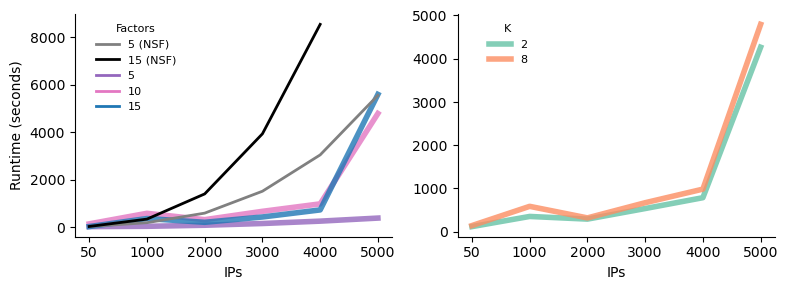

In [330]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Prepare the data for both nnnsf and nsf runtimes
nnnsf_runtime_long5 = nnnsf_runtime_df5.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nnnsf_runtime_long = nnnsf_runtime_df.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nnnsf_runtime_long15 = nnnsf_runtime_df15.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nsf_runtime_long5 = nsf_runtime_df5.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nsf_runtime_long = nsf_runtime_df.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nsf_runtime_long15 = nsf_runtime_df15.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')

# Add 'Number of Neighbors' as a column
nnnsf_runtime_long5['Number of Neighbors'] = nnnsf_runtime_long5['index']
nnnsf_runtime_long['Number of Neighbors'] = nnnsf_runtime_long['index']
nnnsf_runtime_long15['Number of Neighbors'] = nnnsf_runtime_long15['index']
nsf_runtime_long['Number of Neighbors'] = nsf_runtime_long['index']
nsf_runtime_long5['Number of Neighbors'] = nsf_runtime_long5['index']
nsf_runtime_long15['Number of Neighbors'] = nsf_runtime_long15['index']

# Plot nnnsf on the left subplot without legend for 'Number of Neighbors'
sns.lineplot(nnnsf_runtime_long5[nnnsf_runtime_long5['Number of Neighbors'] == 8], x='IPs', y="Runtime", style='Number of Neighbors', linewidth=4, alpha=0.8, color='tab:purple', zorder=0, ax=ax[0], legend=False)
sns.lineplot(nnnsf_runtime_long[nnnsf_runtime_long['Number of Neighbors'] == 8], x='IPs', y="Runtime", style='Number of Neighbors', linewidth=4, alpha=0.8, color='tab:pink', zorder=0, ax=ax[0], legend=False)
sns.lineplot(nnnsf_runtime_long15[nnnsf_runtime_long15['Number of Neighbors'] == 8], x='IPs', y="Runtime", style='Number of Neighbors', linewidth=4, alpha=0.8, color='tab:blue', zorder=0, ax=ax[0], legend=False)
sns.lineplot(nsf_runtime_long5, x='IPs', y="Runtime", linewidth=2, color='gray', alpha=1.0, zorder=1, ax=ax[0], label='5 (NSF)')
#sns.lineplot(nsf_runtime_long, x='IPs', y="Runtime", linewidth=2, color='black', alpha=0.5, zorder=0, ax=ax[0], label='NSF')
sns.lineplot(nsf_runtime_long15, x='IPs', y="Runtime", linewidth=2, color='black', alpha=1.0, zorder=1, ax=ax[0], label='15 (NSF)')

# Plot nnnsf on the right subplot with the legend for 'Number of Neighbors'
#sns.lineplot(nnnsf_runtime_long5, x='IPs', y="Runtime", style='Number of Neighbors', linewidth=2, color='tab:purple', zorder=0, ax=ax[1], legend=False)
sns.lineplot(nnnsf_runtime_long, x='IPs', y="Runtime", hue='Number of Neighbors', linewidth=4, alpha=0.8, palette='Set2', zorder=0, ax=ax[1])
#sns.lineplot(nnnsf_runtime_long15, x='IPs', y="Runtime", hue='Number of Neighbors', linewidth=4, alpha=0.8, palette='Set2', zorder=0, ax=ax[1])

# Create custom legend
custom_lines = [
    Line2D([0], [0], color='gray', alpha=1.0, lw=2),
    Line2D([0], [0], color='black', alpha=1.0, lw=2),
    Line2D([0], [0], color='tab:purple', lw=2),
    Line2D([0], [0], color='tab:pink', lw=2),
    Line2D([0], [0], color='tab:blue', lw=2)
]

# Add the legend to the plot
ax[0].legend(custom_lines, ['5 (NSF)', '15 (NSF)', '5', '10', '15'], title='Factors', loc='upper right', bbox_to_anchor=(0.35, 1.0), frameon=False, fontsize=8, title_fontsize=8)
ax[1].legend(title='K', loc='upper right', bbox_to_anchor=(0.25, 1.0), frameon=False, fontsize=8, title_fontsize=8)

# Set labels for both plots
ax[0].set_ylabel("Runtime (seconds)", size=10)
ax[0].set_xlabel("IPs", size=10)
ax[1].set_ylabel("", size=10)
ax[1].set_xlabel("IPs", size=10)
sns.despine()
# Show the plot
plt.tight_layout()
fig.savefig(f"{FPATH}/slideseq_runntimes.png")
plt.show()

### Model Comparison

In [ ]:
# load NMF
nmf_pois = []
nmf_rmses = []
factors = [5, 10, 15]
for f in factors:
    factors_path = path.join(nmf_path, f"nmf_factors_iter=1000_rs=256_L={f}.npy")
    loadings_path = path.join(nmf_path, f"nmf_loadings_iter=1000_rs=256_L={f}.npy")
    loadings = np.load(loadings_path)
    factors = np.load(factors_path)
    nmf_model = NMF(n_components=f, max_iter=1000, init='random', random_state=256, alpha_H=2e-1, alpha_W=1e-7).fit(y_train)
    y_nmf = nmf_model.inverse_transform(nmf_model.transform(y_train))
    not_strictly_positive_values = y_nmf[y_nmf <= 0]
    epsilon = 1e-10
    y_positive = y_nmf + epsilon
    nmf_rmse = root_mean_squared_error(y_train, y_nmf)
    nmf_poi = mean_poisson_deviance(y_train.flatten(), y_positive.flatten())
    nmf_pois.append(nmf_poi)
    nmf_rmses.append(nmf_rmse)
    print("Done with factor ", f)

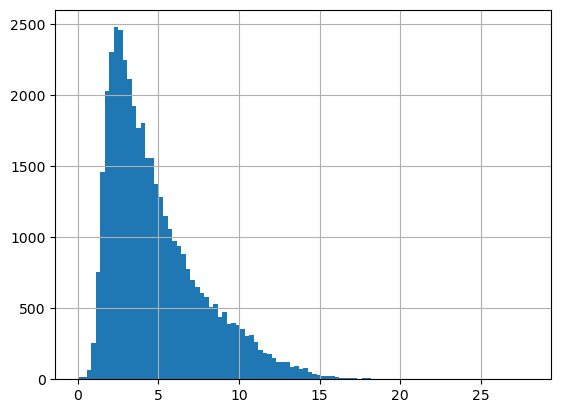

In [24]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)
adata = adata[adata.obs.pct_counts_mt < 20]
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=1)
idx = list(range(adata.shape[0]))
random.shuffle(idx)
adata = adata[idx]
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")
Y = Dtr['Y'].T
X = Dtr['X']*50.0

In [25]:
pnmf_pois = []
pnmf_rmses = []
factors = [5, 10, 15]
for f in factors:
    prior = GaussianPrior(Y, L=f)
    pnmf = PNMF(prior, Y, L=f)
    filepath = f"PNMF_L={f}_lr=0.1_iter=1000_state_dict.pth"
    datapath = path.join(SPATH, 'pnmf')
    dictpath = path.join(datapath, filepath)
    pnmf.load_state_dict(torch.load(dictpath))
    qF, pF = pnmf.prior()
    means = torch.exp(qF.mean).detach().numpy()
    W = pnmf.W
    W_transformed = nn.functional.softplus(W.T)
    W_transformed = W_transformed.detach().numpy()
    y_pnmf = ((means.T)).dot(W_transformed)
    pnmf_rmse = root_mean_squared_error(Y.T, y_pnmf)
    pnmf_poi = mean_poisson_deviance(Y.flatten(), y_pnmf.T.flatten())
    pnmf_rmses.append(pnmf_rmse)
    pnmf_pois.append(pnmf_poi)
    print("Done with factor ", f)

Done with factor  5
Done with factor  10
Done with factor  15


In [91]:
#np.save(path.join(SPATH, 'nmf/nmf_rmses.npy'), nmf_rmses)
#np.save(path.join(SPATH, 'nmf/nmf_pois.npy'), nmf_pois)
#np.save(path.join(SPATH, 'pnmf/pnmf_rmses.npy'), pnmf_rmses)
#np.save(path.join(SPATH, 'pnmf/pnmf_pois.npy'), pnmf_pois)

In [93]:
nmf_rmses = np.load(path.join(SPATH, 'nmf/nmf_rmses.npy'))
nmf_pois = np.load(path.join(SPATH, 'nmf/nmf_pois.npy'))
pnmf_rmses = np.load(path.join(SPATH, 'pnmf/pnmf_rmses.npy'))
pnmf_pois = np.load(path.join(SPATH, 'pnmf/pnmf_rmses.npy'))

In [104]:
nsf_pois_df5 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_poi_nsf_factor5.csv', index_col=0)
nsf_pois_df10 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_poi_nsf_factor10.csv', index_col=0)
nsf_pois_df15 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_poi_nsf_factor15.csv', index_col=0)

nsf_rmses_df5 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_rmse_nsf_factor5.csv', index_col=0)
nsf_rmses_df10 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_rmse_nsf_factor10.csv', index_col=0)
nsf_rmses_df15 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_rmse_nsf_factor15.csv', index_col=0)

In [105]:
nnnsf_pois_df5 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_poi_nnnsf_factor5.csv', index_col=0)
nnnsf_pois_df10 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_poi_nnnsf_factor10.csv', index_col=0)
nnnsf_pois_df15 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_poi_nnnsf_factor15.csv', index_col=0)

nnnsf_rmses_df5 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_rmse_nnnsf_factor5.csv', index_col=0)
nnnsf_rmses_df10 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_rmse_nnnsf_factor10.csv', index_col=0)
nnnsf_rmses_df15 = pd.read_csv('/engelhardt/home/pshrestha/vnngp/results/slideseq/slideseq_rmse_nnnsf_factor15.csv', index_col=0)

In [102]:
nsf_pois_df

15
50    0.076809
1000  0.074350
2000  0.073376
3000  0.072784
4000  0.072508
5000       NaN

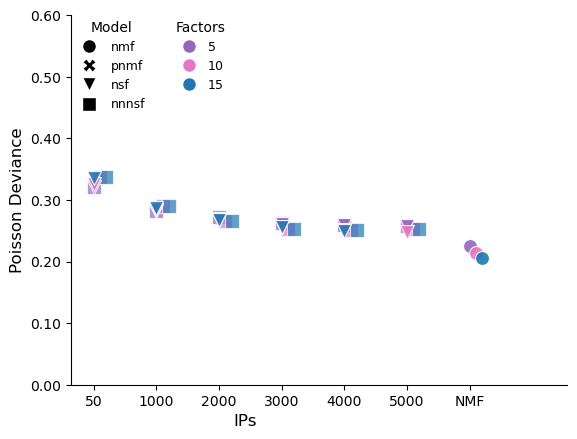

In [120]:
from matplotlib.lines import Line2D

# Initialize the plot
ax = plt.axes() 

# Define labels
L = [5, 10, 15]

# Scatter plots for NMF and PNMF (without offsets)
sns.scatterplot(x=[6], y=[nmf_pois[0]], color='tab:purple', s=100, alpha=0.9)
sns.scatterplot(x=[6 + 0.1], y=[nmf_pois[1]], color='tab:pink', s=100, alpha=0.9)
sns.scatterplot(x=[6 + 2*0.1], y=[nmf_pois[2]], color='tab:blue', s=100, alpha=0.9)

sns.scatterplot(x=[7], y=[pnmf_pois[0]], color='tab:purple', s=120, marker='X', alpha=0.9)
sns.scatterplot(x=[7 + 0.1], y=[pnmf_pois[1]], color='tab:pink', s=120, marker='X', alpha=0.9)
sns.scatterplot(x=[7 + 2*0.1], y=[pnmf_pois[2]], color='tab:blue', s=120, marker='X', alpha=0.9)

# Collect data for nnnsf_pois_df with offset
five_nnnsf = [nnnsf_pois_df5['8'][i] for i in nnnsf_pois_df.index]
ten_nnnsf = [nnnsf_pois_df['8'][i] for i in nnnsf_pois_df.index]
ff_nnnsf = [nnnsf_pois_df15['8'][i] for i in nnnsf_pois_df.index]

# Scatter plots for NNNSF with x-axis offset by 0.1
sns.scatterplot(x=[i for i in range(len(five_nnnsf))], y=five_nnnsf, label=L[0], color='tab:purple', s=100, marker='s', alpha=0.7)
sns.scatterplot(x=[i + 0.1 for i in range(len(ten_nnnsf))], y=ten_nnnsf, label=L[1], color='tab:pink', s=100, marker='s', alpha=0.7)
sns.scatterplot(x=[i + 2 * 0.1 for i in range(len(ff_nnnsf))], y=ff_nnnsf, label=L[2], color='tab:blue', s=100, marker='s', alpha=0.7)

# Collect data for nsf_pois_df
five_nsf = [nsf_pois_df5['5'][i] for i in nsf_pois_df.index]
ten_nsf = [nsf_pois_df10['10'][i] for i in nsf_pois_df.index]
ff_nsf = [nsf_pois_df15['15'][i] for i in nsf_pois_df.index]

# Scatter plots for NSF
sns.scatterplot(x=[i for i in range(len(five_nsf))], y=five_nsf, label=L[0], color='tab:purple', s=100, marker='v', alpha=0.9)
sns.scatterplot(x=[i for i in range(len(ten_nsf))], y=ten_nsf, label=L[1], color='tab:pink', s=100, marker='v', alpha=0.9)
sns.scatterplot(x=[i for i in range(len(ff_nsf))], y=ff_nsf, label=L[2], color='tab:blue', s=100, marker='v', alpha=0.9)

sns.scatterplot(x=[3.5], y=[0.75], color='w', zorder=5, s=200, marker='s')

# Configure axes
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(['50', '1000', '2000', '3000', '4000', '5000', 'NMF'], fontsize=10)
ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], fontsize=10)

# Legends
leg1_elem = [
    Line2D([0], [0], color='w', lw=4, label='nmf', marker='o', markerfacecolor='black', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='pnmf', marker='X', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nsf', marker='v', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nnnsf', marker='s', markerfacecolor='black', markersize=10)
]
leg1 = plt.legend(
    handles=leg1_elem, 
    bbox_to_anchor=(0, 1.0), 
    loc="upper left", 
    title="Model", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
   
)

leg2_elem = [
    Line2D([0], [0], color='w', lw=4, label='5', marker='o', markerfacecolor='tab:purple', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='10', marker='o', markerfacecolor='tab:pink', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='15', marker='o', markerfacecolor='tab:blue', markersize=10)
]
leg2 = plt.legend(
    handles=leg2_elem, 
    bbox_to_anchor=(0.20, 1.0), 
    loc="upper left", 
    title="Factors", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
    handletextpad=0.5
)


# Add legends and labels
ax.add_artist(leg1)
ax.set_ylim(0.06, 0.09)
ax.set_xlabel("IPs", size=12, x=0.35)
ax.set_ylabel("Poisson Deviance", size=12)
#ax.set_title("Model Goodness of Fit Comparison")
sns.despine()
# Show the plot
plt.savefig(f'{SPATH}/slideseq_goodness_of_fit_without_hybrid_models.png', bbox_inches='tight')
plt.show()

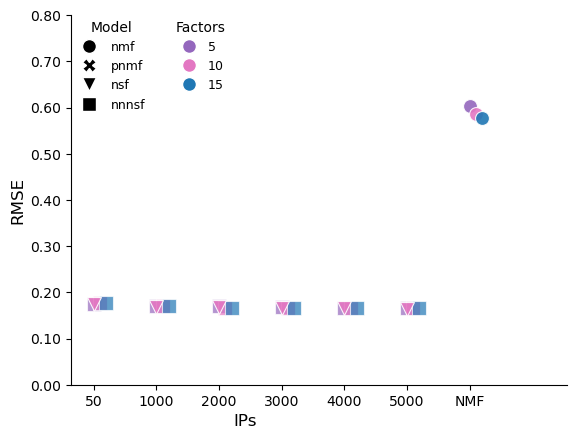

In [119]:
from matplotlib.lines import Line2D

# Initialize the plot
ax = plt.axes() 

# Define labels
L = [5, 10, 15]

# Scatter plots for NMF and PNMF (without offsets)
sns.scatterplot(x=[6], y=[nmf_rmses[0]], color='tab:purple', s=100, alpha=0.9)
sns.scatterplot(x=[6 + 0.1], y=[nmf_rmses[1]], color='tab:pink', s=100, alpha=0.9)
sns.scatterplot(x=[6 + 2*0.1], y=[nmf_rmses[2]], color='tab:blue', s=100, alpha=0.9)

sns.scatterplot(x=[7], y=[pnmf_rmses[0]], color='tab:purple', s=120, marker='X', alpha=0.9)
sns.scatterplot(x=[7 + 0.1], y=[pnmf_rmses[1]], color='tab:pink', s=120, marker='X', alpha=0.9)
sns.scatterplot(x=[7 + 2*0.1], y=[pnmf_rmses[2]], color='tab:blue', s=120, marker='X', alpha=0.9)

# Collect data for nnnsf_pois_df with offset
five_nnnsf = [nnnsf_rmses_df5['8'][i] for i in nnnsf_pois_df.index]
ten_nnnsf = [nnnsf_rmses_df['8'][i] for i in nnnsf_pois_df.index]
ff_nnnsf = [nnnsf_rmses_df15['8'][i] for i in nnnsf_pois_df.index]

# Scatter plots for NNNSF with x-axis offset by 0.1
sns.scatterplot(x=[i for i in range(len(five_nnnsf))], y=five_nnnsf, label=L[0], color='tab:purple', s=100, marker='s', alpha=0.7)
sns.scatterplot(x=[i + 0.1 for i in range(len(ten_nnnsf))], y=ten_nnnsf, label=L[1], color='tab:pink', s=100, marker='s', alpha=0.7)
sns.scatterplot(x=[i + 2 * 0.1 for i in range(len(ff_nnnsf))], y=ff_nnnsf, label=L[2], color='tab:blue', s=100, marker='s', alpha=0.7)

# Collect data for nsf_pois_df
five_nsf = [nsf_rmses_df5['5'][i] for i in nsf_pois_df.index]
ten_nsf = [nsf_rmses_df10['10'][i] for i in nsf_pois_df.index]
ff_nsf = [nsf_rmses_df15['15'][i] for i in nsf_pois_df.index]

# Scatter plots for NSF
#sns.scatterplot(x=[i for i in range(len(five_nsf))], y=five_nsf, label=L[0], color='tab:purple', s=100, marker='v', alpha=0.9)
sns.scatterplot(x=[i for i in range(len(ten_nsf))], y=ten_nsf, label=L[1], color='tab:pink', s=100, marker='v', alpha=0.9)
#sns.scatterplot(x=[i for i in range(len(ff_nsf))], y=ff_nsf, label=L[2], color='tab:blue', s=100, marker='v', alpha=0.9)

sns.scatterplot(x=[3.5], y=[0.75], color='w', zorder=5, s=200, marker='s')

# Configure axes
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(['50', '1000', '2000', '3000', '4000', '5000', 'NMF'], fontsize=10)
ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], fontsize=10)

# Legends
leg1_elem = [
    Line2D([0], [0], color='w', lw=4, label='nmf', marker='o', markerfacecolor='black', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='pnmf', marker='X', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nsf', marker='v', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nnnsf', marker='s', markerfacecolor='black', markersize=10)
]
leg1 = plt.legend(
    handles=leg1_elem, 
    bbox_to_anchor=(0, 1.0), 
    loc="upper left", 
    title="Model", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
   
)

leg2_elem = [
    Line2D([0], [0], color='w', lw=4, label='5', marker='o', markerfacecolor='tab:purple', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='10', marker='o', markerfacecolor='tab:pink', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='15', marker='o', markerfacecolor='tab:blue', markersize=10)
]
leg2 = plt.legend(
    handles=leg2_elem, 
    bbox_to_anchor=(0.20, 1.0), 
    loc="upper left", 
    title="Factors", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
    handletextpad=0.5
)


# Add legends and labels
ax.add_artist(leg1)
ax.set_ylim(0.06, 0.1)
ax.set_xlabel("IPs", size=12, x=0.35)
ax.set_ylabel("RMSE", size=12)
#ax.set_title("Model Goodness of Fit Comparison")
sns.despine()
# Show the plot
plt.savefig(f'{SPATH}/slideseq_goodness_of_fit_without_hybrid_models_rmse.png', bbox_inches='tight')
plt.show()

### Factors

In [373]:
params = {
        'L': 15, 
        'M': 4000, 
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 64,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'SVGP',
        'L1_jitter': 1e-1}

In [374]:
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={params['L']}.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={params['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

In [375]:
loadings.shape

(17702, 15)

In [376]:
NSF = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='SVGP', kwargs=params)

In [ ]:
file_path = f"SVGP_M={params['M']}_L={params['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"SVGP_M={params['M']}_L={params['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nsf_path, file_path)
model_path = path.join(nsf_path, modelname)
NSF.load_state_dict(torch.load(dict_path))
nsf_model_dict = torch.load(model_path)

In [ ]:
X_train = torch.tensor(X_train).type(torch.float)
rmse = putil.evaluate_model(NSF, X_train, y_train, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=params)
poid = putil.evaluate_model(NSF, X_train, y_train, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=params)

print("Iterations: ", len(nsf_model_dict['losses']))
print("Runtime: ", (nsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

In [ ]:
NSF.cpu()
qF, _, _ = NSF.prior(X_train, kwargs=params)
    
means_nsf = torch.exp(qF.mean).detach().numpy() # means = factors
moran_idx = moran_idx.astype(int)

In [ ]:
fig2, ax = putil.plot_factors(means_nsf, X_train.cpu().detach().numpy(), size=1.5, s=0.05, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(nums)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NSF", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
fig2.savefig(f"{FPATH}/nsf_l={params['L']}_m={params['M']}.png")
#plt.close()

In [380]:
dicts = {
    'L': 10, 
    'M': 5000, 
    'K': 8,
    'sigma': 1.0, 
    'lengthscale': 1.2, 
    'jtr': 0.01,
    'batch_size': 128,
    'lr': 0.01,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

In [378]:
NNNSF1 = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)

In [382]:
file_path = f"new_training/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.01_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"new_training/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.01_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF1.load_state_dict(torch.load(dict_path))
nnnsf1_model_dict = torch.load(model_path)

In [383]:
X_train = torch.tensor(X_train).type(torch.float)
rmse = putil.evaluate_model(NNNSF1, X_train, y_train, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF1, X_train, y_train, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf1_model_dict['losses']))
print("Runtime: ", (nnnsf1_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

Iterations:  40000
Runtime:  6108.74521613121
RMSE:  0.09149342
Poisson Deviance:  0.07249263


In [384]:
NNNSF1.cpu()
qF, _, _ = NNNSF1.prior(X_train, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors
moran_idx = moran_idx.astype(int)

(2, 5)


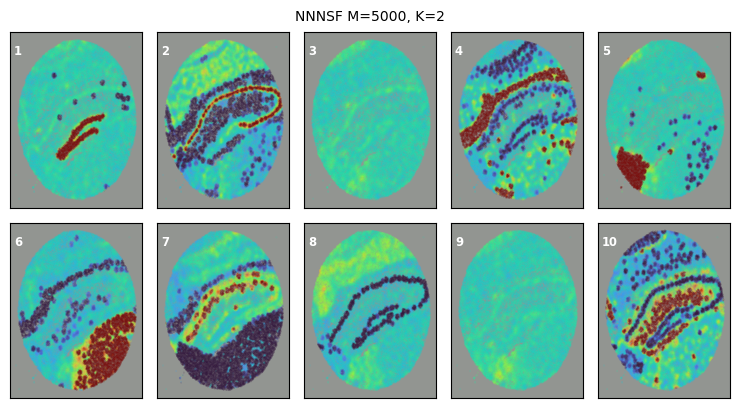

In [388]:
fig2, ax = putil.plot_factors(np.exp(means), X_train.cpu().detach().numpy(), size=1.5, s=0.005, alpha=1, ax=None, names=None, moran_idx=moran_idx)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(nums)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSF M=5000, K=2", size=10, y=0.95)
fig2.set_figheight(4.25)
fig2.tight_layout()
#fig2.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

In [57]:
dicts = {
    'L': 15, 
    'M': 1000, 
    'K': 2,
    'sigma': 1.0, 
    'lengthscale': 1.2, 
    'jtr': 0.01,
    'batch_size': 128,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)
factors = factors[:, moran_idx]
loadings = loadings[:, moran_idx]

In [58]:
NNNSF2 = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)

In [59]:
file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF2.load_state_dict(torch.load(dict_path))
nnnsf2_model_dict = torch.load(model_path)

In [60]:
X_train = torch.tensor(X_train).type(torch.float)
rmse = putil.evaluate_model(NNNSF2, X_train, y_train, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF2, X_train, y_train, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf2_model_dict['losses']))
print("Runtime: ", (nnnsf2_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

Iterations:  25000
Runtime:  371.2161555290222
RMSE:  0.09140036
Poisson Deviance:  0.07242153


In [364]:
NNNSF2.cpu()
qF, _, _ = NNNSF2.prior(X_train, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors
moran_idx = moran_idx.astype(int)

(3, 5)


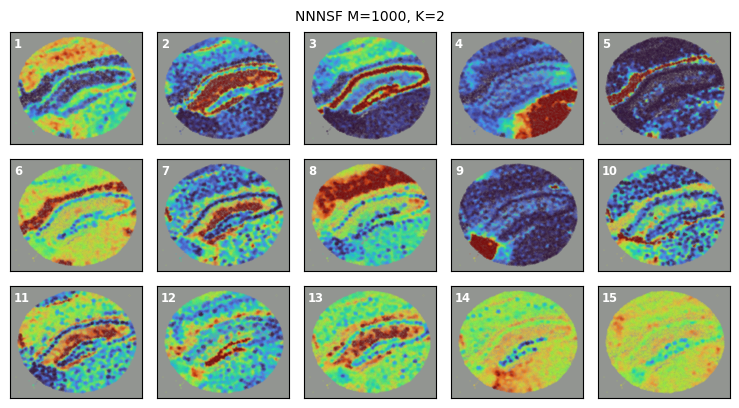

In [372]:
fig2, ax = putil.plot_factors(np.exp(means), X_train.cpu().detach().numpy(), size=1.5, s=0.003, alpha=0.9, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(nums)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSF M=1000, K=2", size=10, y=0.95)
fig2.set_figheight(4.25)
fig2.tight_layout()
#fig2.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

#### Double Exponentiated Factors

(2, 5)


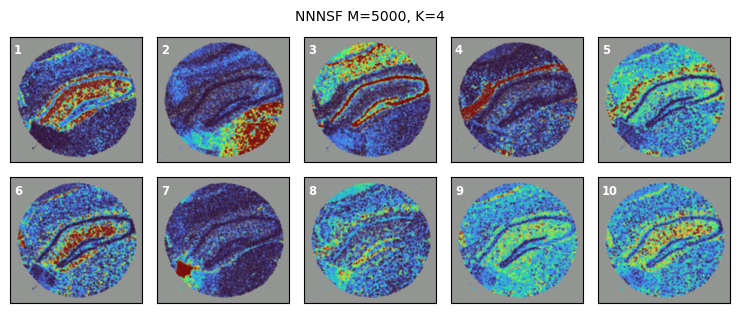

In [52]:

fig2, ax = putil.plot_factors(np.exp(np.exp(means)), X_train.cpu().detach().numpy(), size=1.5, s=0.005, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(names)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSF M=5000, K=4", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
fig2.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

#### K = 8

In [ ]:
dicts = {
    'L': 10, 
    'M': 1000, 
    'K': 8,
    'sigma': 1.0, 
    'lengthscale': 1.2, 
    'jtr': 0.01,
    'batch_size': 128,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

In [ ]:
NNNSF3 = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)

In [ ]:
file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF3.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

In [ ]:
X_train = torch.tensor(X_train).type(torch.float)
rmse = putil.evaluate_model(NNNSF3, X_train, y_train, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF3, X_train, y_train, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf_model_dict['losses']))
print("Runtime: ", (nnnsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

In [ ]:
NNNSF3.cpu()
qF, _, _ = NNNSF3.prior(X_train, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors
moran_idx = moran_idx.astype(int)

In [ ]:
# Double Exponentiated Factors
fig2, ax = putil.plot_factors(means, X_train.cpu().detach().numpy(), size=1.5, s=0.005, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(nums)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSF M=1000, K=8", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
fig2.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

In [ ]:
dicts = {
    'L': 10, 
    'M': 5000, 
    'K': 8,
    'sigma': 1.0, 
    'lengthscale': 1.2, 
    'jtr': 0.01,
    'batch_size': 128,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

In [94]:
NNNSF4 = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)

In [ ]:
file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF4.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

In [ ]:
X_train = torch.tensor(X_train).type(torch.float)
rmse = putil.evaluate_model(NNNSF4, X_train, y_train, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF4, X_train, y_train, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf_model_dict['losses']))
print("Runtime: ", (nnnsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

In [ ]:
NNNSF4.cpu()
qF, _, _ = NNNSF4.prior(X_train, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors
moran_idx = moran_idx.astype(int)

In [ ]:
fig2, ax = putil.plot_factors(means, X_train.cpu().detach().numpy(), size=1.5, s=0.005, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(nums)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSF M=5000, K=8", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
fig2.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

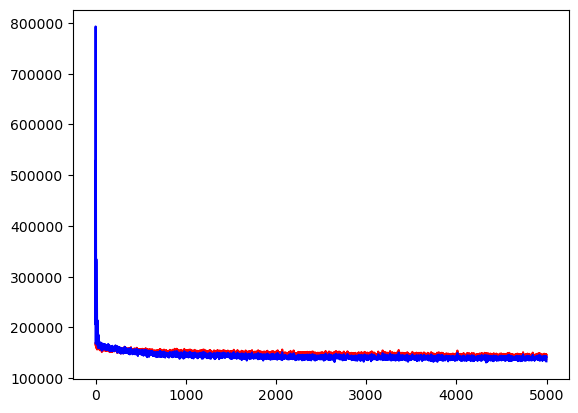

In [107]:
plt.plot(nnnsf_model_dict['losses'], color='red')
plt.plot(nsf_model_dict['losses'], color='blue')
#plt.xlim(0, 200)

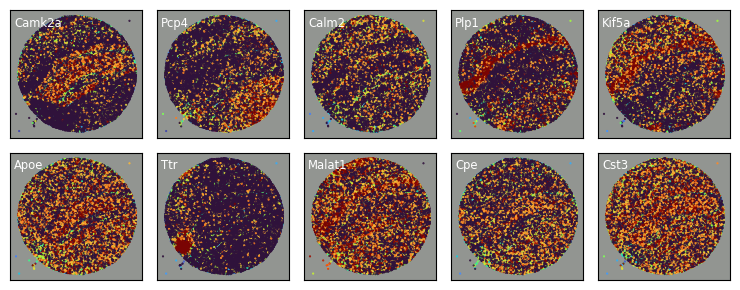

In [146]:
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, np.array(X_train))
factors = factors[:, moran_idx]
loadings = loadings[:, moran_idx]
loadings_softmax = torch.nn.functional.softmax(torch.tensor(loadings), dim=1)
names = adata.var.index[loadings_softmax.argmax(axis=0)]
fig, ax = putil.plot_factors(y_train[loadings_softmax.argmax(axis=0)], np.array(X_train), size=1.5, s=0.3, alpha=1, names=names)
fig.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}_genes.png")

In [151]:
W = torch.nn.functional.softplus(NNNSF.W)

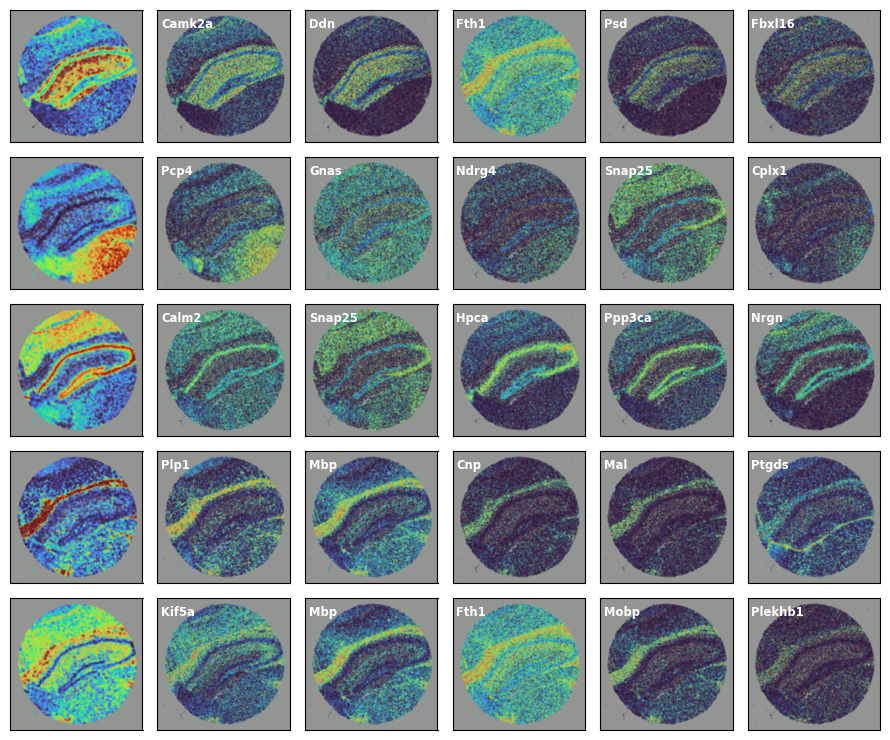

In [153]:
fig = plot_top_genes(means, W, X_train, y_train, num_genes=5, size=1.5, alpha=0.9, s=0.005)
fig.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}_5genes.png")
fig.show()

In [76]:
dicts = {
    'L': 12, 
    'M': 4000, 
    'K': 8,
    'sigma': 1.0, 
    'lengthscale': 1.7, 
    'jtr': 0.01,
    'batch_size': 128,
    'lr': 0.0001,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L=23.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L=23.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)
print(factors.shape)
print(loadings.shape)

(39694, 23)
(17702, 23)


In [77]:
NNNSFH = putil.build_model_hybrid(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)

MODEL SHAPES
torch.Size([17702, 12])
torch.Size([17702, 11])
torch.Size([17702, 11])


In [78]:
nnnsfh_path = path.join(SPATH, 'nnnsfh/validation_experiments')

In [79]:
file_path = f"VNNGP_K={dicts['K']}_M={dicts['M']}_L={dicts['L']}_lr=0.0001_jtr=0.01_ls=1.7_sigma=1.0_bs=128_2_state_dict.pth"
modelname = f"VNNGP_K={dicts['K']}_M={dicts['M']}_L={dicts['L']}_lr=0.0001_jtr=0.01_ls=1.7_sigma=1.0_bs=128_2_model.pt"
dict_path = path.join(nnnsfh_path, file_path)
model_path = path.join(nnnsfh_path, modelname)
NNNSFH.load_state_dict(torch.load(dict_path))
nnnsfh_model_dict = torch.load(model_path)
#vnngp/results/slideseq/nnnsfh/validation_experiments/VNNGP_K=8_M=5000_L=10_lr=0.01_jtr=0.01_ls=1.2_sigma=1.0_bs=128_state_dict.pth

In [80]:
X_train = torch.tensor(X_train).type(torch.float)
rmse = putil.evaluate_model(NNNSFH, X_train, y_train, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSFH, X_train, y_train, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsfh_model_dict['losses']))
print("Runtime: ", (nnnsfh_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

Iterations:  432000
Runtime:  45606.70433449745
RMSE:  0.09404774
Poisson Deviance:  0.077822536


In [81]:
NNNSFH.cpu()
qF, _, _ = NNNSFH.sf.prior(X_train, kwargs=dicts)
qFc, _ = NNNSFH.cf.prior()
    
means = torch.exp(qF.mean).detach().numpy() # means = factors
meansc = torch.exp(qFc.mean).detach().numpy() # means = factors
moran_idx = moran_idx.astype(int)

In [82]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(L//6, 6, figsize=(size*6, size*(L//6)), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//6, i%6]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
            
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')
    return fig, ax

(2, 6)


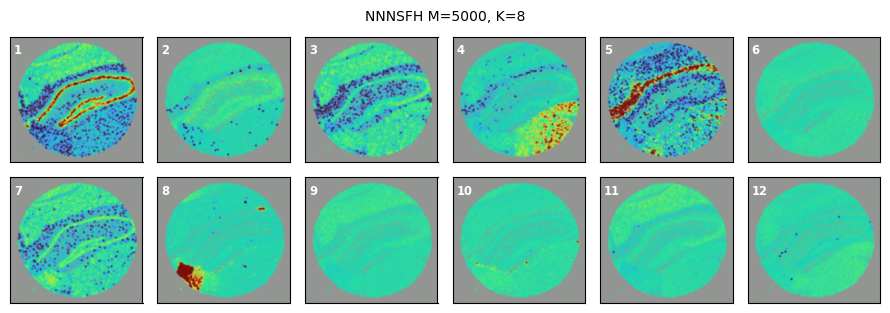

In [89]:
fig2, ax = plot_factors(np.exp(means), X_train.cpu().detach().numpy(), size=1.5, s=0.005, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//6, i%6]
    curr_ax.set_title(np.array(nums)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSFH M=5000, K=8", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
#fig2.savefig(f"{FPATH}/nnnsfh_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

In [85]:
print(meansc.shape)
fake_row = torch.zeros(1, meansc.shape[1])
meansc = torch.tensor(meansc) 
fake_row = torch.tensor(fake_row) 
meansc_expanded = torch.cat((meansc, fake_row), dim=0)

(11, 39694)


(2, 6)


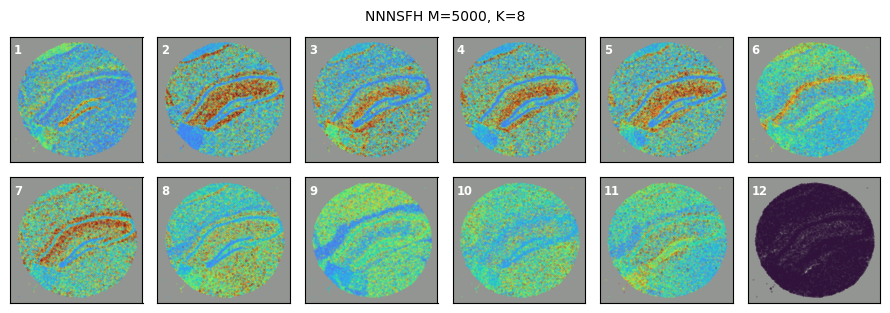

In [87]:
fig2, ax = plot_factors(np.exp(meansc_expanded), X_train.cpu().detach().numpy(), size=1.5, s=0.01, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//6, i%6]
    curr_ax.set_title(np.array(nums)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSFH M=5000, K=8", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
#fig2.savefig(f"{FPATH}/nnnsfh_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

In [103]:
loadings_softmax.shape

torch.Size([17702, 19])

In [110]:
loadings_softmax[:, :dicts['L']].shape

torch.Size([17702, 10])

In [124]:
W = NNNSF.cf.W.shape
W

torch.Size([17702, 9])

In [447]:
W = NNNSFH.cf.W
fake_row = torch.zeros(W.shape[0], 1)
fake_row = torch.tensor(fake_row) 
W_expanded = torch.cat((W, fake_row), dim=1)

In [448]:
W_expanded.shape

torch.Size([17702, 12])

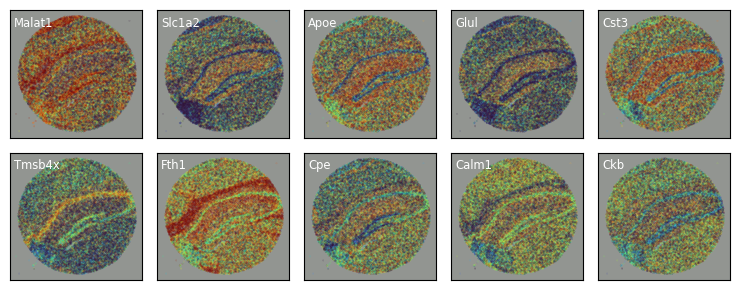

In [449]:
#factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
#loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
#factors = np.load(factors_path)
#loadings = np.load(loadings_path)
#moran_idx, moranI = putil.dims_autocorr(factors, np.array(X_train))
#factors = factors[:, moran_idx]
#loadings = loadings[:, moran_idx]
#loadings_softmax = torch.nn.functional.softmax(torch.tensor(loadings), dim=1)
names = adata.var.index[W_expanded[:, :dicts['L']].argmax(axis=0)]
fig, ax = putil.plot_factors(y_train[W_expanded[:, :dicts['L']].argmax(axis=0)], np.array(X_train), size=1.5, s=0.007, alpha=0.9, names=names)
fig.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}_genes.png")

### FLOPS

In [10]:
from ptflops import get_model_complexity_info

In [11]:
# NSF 5, 10, 15, N=3000
dicts = {
        'L': 10, 
        'M': 5000, 
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'SVGP',
        'L1_jitter': 1e-1}
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L=10.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L=10.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)
filepath = f"SVGP_M={dicts['M']}_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
dictpath = path.join(nsf_path, filepath)
NSF = putil.build_model(X_train, y_train, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)

In [16]:
NSF.load_state_dict(torch.load(dictpath))
torch.cuda.empty_cache()
NSF.to('cuda')  # Move model to GPU
torch.cuda.reset_peak_memory_stats()
print(f"Memory allocated after loading model: {torch.cuda.memory_allocated()} bytes")
total_params = sum(p.numel() for p in NSF.parameters())
print(f"Total number of parameters in the reloaded model: {total_params}")

Memory allocated after loading model: 2002900992 bytes
Total number of parameters in the reloaded model: 250276734


In [13]:
# NNNSF 10 N=3000
dicts = {
        'L': 10, 
        'M': 5000, 
        'K':2,
        'sigma': 1.0, 
        'lengthscale': 1.2, 
        'jtr': 0.01,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L=10.npy")
loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L=10.npy")
print(factors.shape)
print(loadings.shape)
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)
file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
dictpath = path.join(nnnsf_path, file_path)
NNNSF = putil.build_model(X_train, y_train, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)

#vnngp/results/slideseq/nnnsf/VNNGP_K=2_lkzz=1_M=1000_L=10_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_loss.png

(39694, 10)
(17702, 10)


In [15]:
NNNSF.load_state_dict(torch.load(dictpath))
torch.cuda.empty_cache()
NNNSF.to('cuda')  # Move model to GPU
print(f"Memory allocated after loading model: {torch.cuda.memory_allocated()} bytes")
print(f"Peak memory allocated: {torch.cuda.max_memory_allocated()} bytes")
total_params = sum(p.numel() for p in NNNSF.parameters())
print(f"Total number of parameters in the reloaded model: {total_params}")

Memory allocated after loading model: 2002900992 bytes
Peak memory allocated: 3004351488 bytes
Total number of parameters in the reloaded model: 250276734


In [90]:


#SVGP_M=50_L=15_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth

# NSF 5, 10, 15, N=3000

# NNNSF L=5, K=2, M=1000

# NNNSF L=5, K=8, M=1000

# NNNSF L=5, K=2, M=3000

# NNNSF L=5, K=8, M=3000

# NNNSF L=10, K=2, M=1000

# NNNSF L=10, K=8, M=1000

# NNNSF L=10, K=2, M=3000

# NNNSF L=10, K=8, M=3000

# NNNSF L=15, K=2, M=1000

# NNNSF L=15, K=8, M=1000

# NNNSF L=15, K=2, M=3000

# NNNSF L=15, K=8, M=3000


## Biological Significance

In [412]:
dicts = {
    'L': 10, 
    'M': 5000, 
    'K': 4,
    'sigma': 1.0, 
    'lengthscale': 1.2, 
    'jtr': 0.01,
    'batch_size': 128,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

In [413]:
NNNSF4 = putil.build_model(np.array(X_train), np.array(y_train), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)

In [414]:
file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_ls=1.2_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF4.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

In [415]:
X_train = torch.tensor(X_train).type(torch.float)
rmse = putil.evaluate_model(NNNSF4, X_train, y_train, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF4, X_train, y_train, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf_model_dict['losses']))
print("Runtime: ", (nnnsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

Iterations:  5000
Runtime:  756.9740550518036
RMSE:  0.091407284
Poisson Deviance:  0.07251956


In [416]:
NNNSF4.cpu()
qF, _, _ = NNNSF4.prior(X_train, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors
moran_idx = moran_idx.astype(int)

In [417]:
W = torch.nn.functional.softplus(NNNSF4.W)

In [418]:
def plot_top_genes(factors, loadings, X, y, num_genes=5, size=2, alpha=0.8, s=0.1, names=None):

    max_val_factors = np.percentile(factors, 99)
    min_val_factors = np.percentile(factors, 1)

    L = len(factors)


    loadings_softmax = torch.nn.functional.softmax(loadings, dim=1)

    order = torch.argsort(loadings_softmax, dim=0, descending=True)

    y_top = y[order[:num_genes]]
    fig, ax = plt.subplots(L, num_genes+1, figsize=(size*(num_genes+1), size*L), tight_layout=True)

    for i in range(L):
        

        curr_ax = ax[i, 0]
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val_factors, vmax=max_val_factors, alpha=alpha, cmap='turbo', s=s)
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

        names = adata.var.index[order[:num_genes, i]]


        for j in range(num_genes):
            
            curr_ax = ax[i, j+1]
            curr_ax.scatter(X[:, 0], X[:,1], c=y_top[j, i], alpha=alpha, cmap='turbo', s=s)
            curr_ax.invert_yaxis()
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])
            curr_ax.set_facecolor('xkcd:gray')

            curr_ax.set_title(names[j], x=0.03, y=.88, fontsize="small", c="white",
                         ha="left", va="top", fontweight="bold")
    return fig
    
def normalize_rows(loadings):
    """
    Normalize rows of the loadings matrix such that each row sums to 1.

    Parameters:
        loadings (numpy.ndarray): A 2D array of shape (n_genes, n_components).

    Returns:
        numpy.ndarray: The normalized loadings matrix.
    """
    # Compute row sums
    row_sums = loadings.sum(axis=1, keepdims=True)
    
    # Avoid division by zero (if a row sum is zero, leave the row unchanged)
    row_sums[row_sums == 0] = 1
    
    # Normalize each row
    normalized_loadings = loadings / row_sums
    
    return normalized_loadings
    
def get_top_genes(factors, loadings, y, adata, num_factors=5, num_genes=5):
    """
    Extracts the top genes for the top spatially correlated factors.
    
    Args:
        factors (np.ndarray): Array of factors (e.g., PCA, NMF, etc.).
        loadings (torch.Tensor): Loadings matrix (e.g., factor loadings).
        adata (AnnData): AnnData object containing gene names in `var`.
        num_factors (int): Number of top spatially correlated factors to extract.
        num_genes (int): Number of top genes to extract for each factor.
    
    Returns:
        dict: Dictionary with factor indices as keys and corresponding top gene names as values.
    """

    loadings_softmax = torch.nn.functional.softmax(torch.tensor(loadings), dim=1)
    order = torch.argsort(loadings_softmax, dim=0, descending=True)
    genes = {}
    for i in range(num_factors):
        names = list(adata.var.index[order[:num_genes, i]])
        genes[i] = names
    return genes

In [419]:
loadings_normalized = normalize_rows(W)

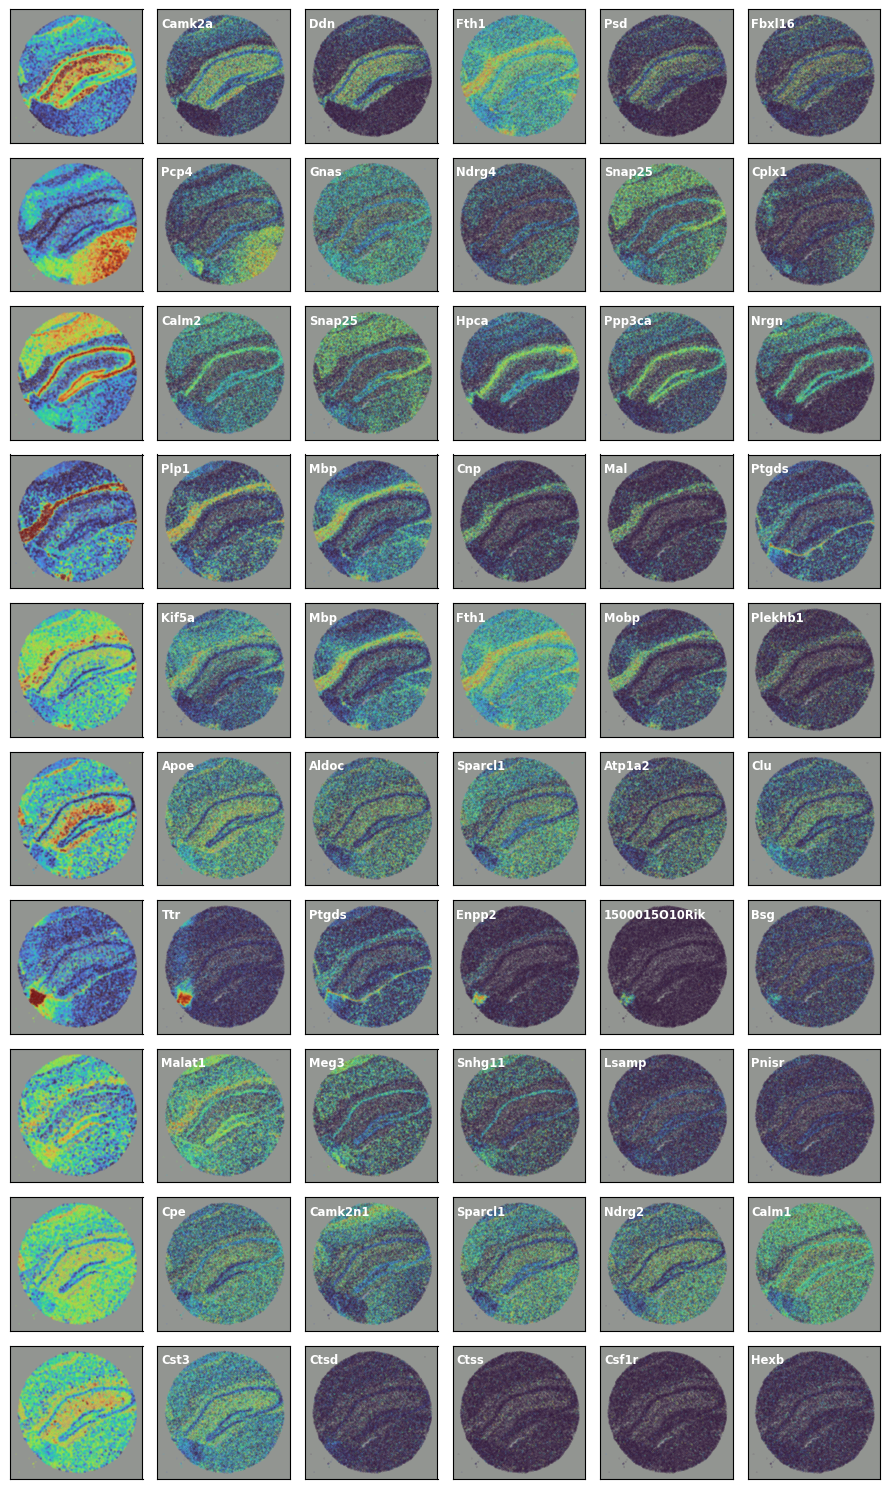

In [420]:
fig = plot_top_genes(means, W, X_train, y_train, num_genes=5, size=1.5, alpha=0.7, s=0.005)

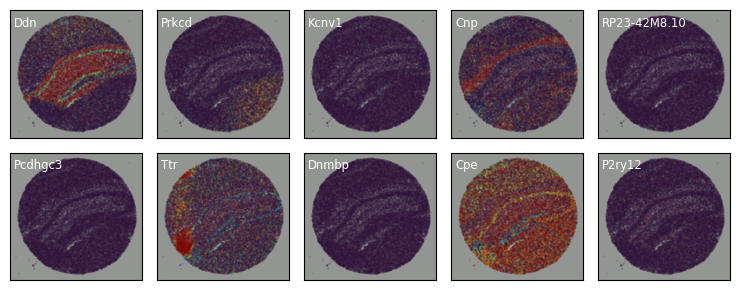

In [421]:
names = adata.var.index[loadings_normalized.argmax(axis=0)]
fig, ax = putil.plot_factors(y_train[loadings_normalized.argmax(axis=0)], np.array(X_train), size=1.5, s=0.007, alpha=0.9, names=names)
fig.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}_genes.png")

In [422]:
top_genes = get_top_genes(factors, W, y_train, adata, num_factors=10, num_genes=5)

In [423]:
top_genes

{0: ['Camk2a', 'Ddn', 'Fth1', 'Psd', 'Fbxl16'],
 1: ['Pcp4', 'Gnas', 'Ndrg4', 'Snap25', 'Cplx1'],
 2: ['Calm2', 'Snap25', 'Hpca', 'Ppp3ca', 'Nrgn'],
 3: ['Plp1', 'Mbp', 'Cnp', 'Mal', 'Ptgds'],
 4: ['Kif5a', 'Mbp', 'Fth1', 'Mobp', 'Plekhb1'],
 5: ['Apoe', 'Aldoc', 'Sparcl1', 'Atp1a2', 'Clu'],
 6: ['Ttr', 'Ptgds', 'Enpp2', '1500015O10Rik', 'Bsg'],
 7: ['Malat1', 'Meg3', 'Snhg11', 'Lsamp', 'Pnisr'],
 8: ['Cpe', 'Camk2n1', 'Sparcl1', 'Ndrg2', 'Calm1'],
 9: ['Cst3', 'Ctsd', 'Ctss', 'Csf1r', 'Hexb']}

In [429]:
enrichment_results = {}
for factor_idx, genes in top_genes.items():
    print(f"Running GO enrichment for Factor {factor_idx}...")
    enr = gps.enrichr(gene_list=genes, gene_sets=['GO_Biological_Process_2021', 'GO_Cellular_Component_2021'], organism='Mouse', outdir=None)
    combined_results = pd.concat([enr.results], ignore_index=True)
    enrichment_results[factor_idx] = combined_results

Running GO enrichment for Factor 0...
Running GO enrichment for Factor 1...
Running GO enrichment for Factor 2...
Running GO enrichment for Factor 3...
Running GO enrichment for Factor 4...
Running GO enrichment for Factor 5...
Running GO enrichment for Factor 6...
Running GO enrichment for Factor 7...
Running GO enrichment for Factor 8...
Running GO enrichment for Factor 9...


In [430]:
gsea_results = enrichment_results.copy()

In [431]:
for factor_idx, genes in top_genes.items():
    enrichment_results[factor_idx] = enrichment_results[factor_idx][enrichment_results[factor_idx]['P-value'] < 0.05]

In [445]:
print(*enrichment_results[9][:3]['Term'].items())

(0, 'neutrophil degranulation (GO:0043312)') (1, 'neutrophil activation involved in immune response (GO:0002283)') (2, 'neutrophil mediated immunity (GO:0002446)')
